# Task N.1 - Xtend

Implement position and velocity estimation based on 2 optical flow velocity sensor readings.

## Section 1 - extract the provided excel data

In order to conduct this I am going to use the `pandas` and `numpy` packages to extract 3 numpy arrays from the .xlsx file. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd

data_file_path = 'Velocity sensors data.xlsx'

df = pd.read_excel(data_file_path)

# extract data from excel file
time_us = df['time[us]'].to_numpy()
flow_velocity_1_cms = df['flowVelocityX[cm/s]'].to_numpy()
flow_velocity_2_cms = df['secFlowVelocityX[cm/s]'].to_numpy()

### displaying the measured data 

Now we are going to display the data to get a sense of the nature of the readings

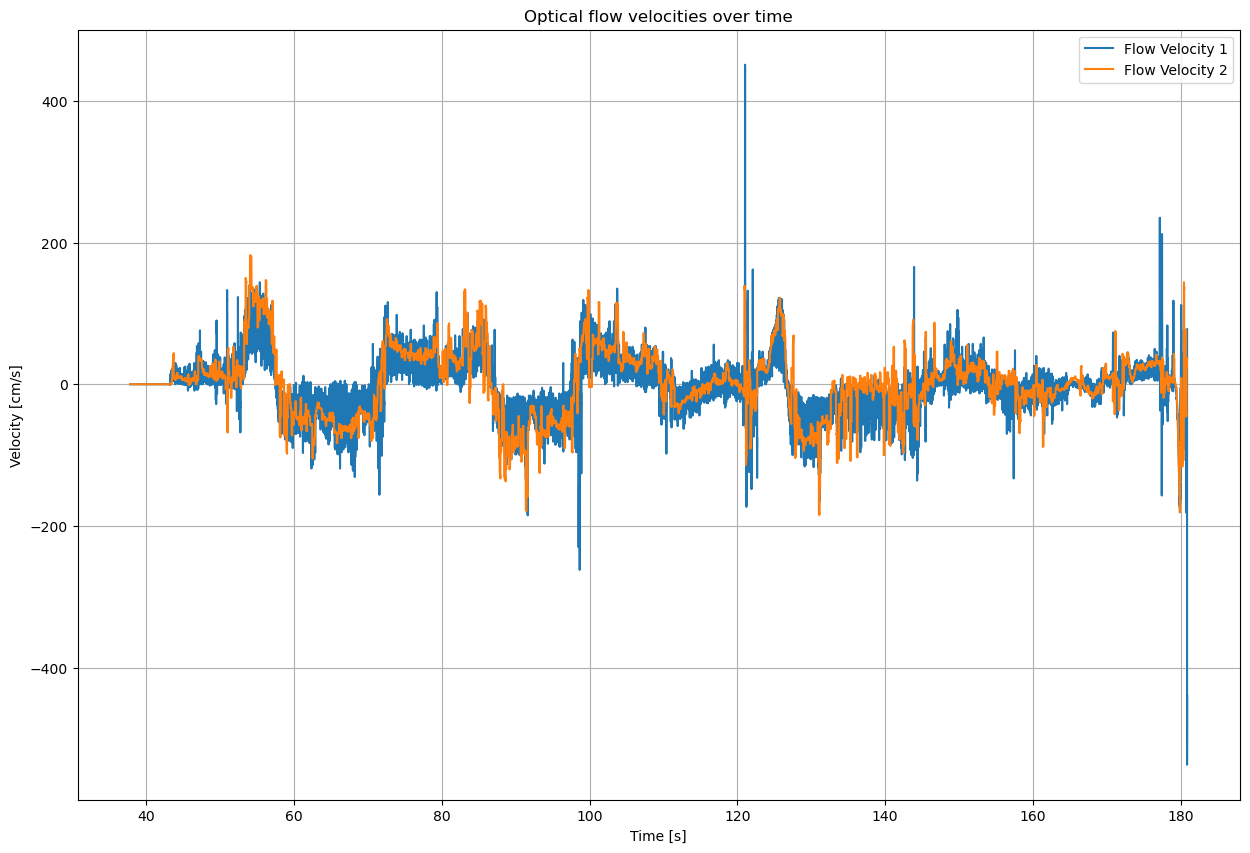

In [13]:
time_s = time_us * 1e-6
plt.figure(figsize=(15, 10))
plt.plot(time_s,flow_velocity_1_cms, label='Flow Velocity 1')
plt.plot(time_s, flow_velocity_2_cms, label='Flow Velocity 2')
plt.grid(True);


plt.title("Optical flow velocities over time")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [cm/s]")

plt.legend()
plt.show()

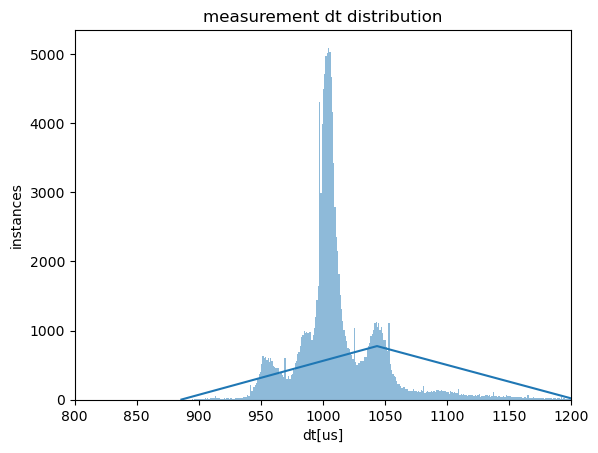

In [4]:
# measurement time distribution

dt = np.diff(time_us)

data = dt

sns.histplot(data, kde=True) 
plt.title('measurement dt distribution')
plt.xlim(800,1200)
plt.xlabel('dt[us]')
plt.ylabel('instances')
plt.show()

In [5]:
print("average sampling time:")
print(np.average(dt))
print(np.var(dt))

average sampling time:
1013.4356726803759
14061.042477690173


We would like to achieve a system state estimation from the above velocity data. the estimation must include both the system position and velocity. we can achieve this with 3 approaches:

### 1. moving average filtering

This is a naive approach. it will reduce system noise but will also introduce phase lag which is proportional to the number of members present in the moving average calculation. also we achieve a non-smooth attenuation and phase shift curves.

## 3. Kalman filter


### Kalman filter design

In order to design the kalman filter we must first derive that state-space relations between the sensor input values and the system state estimation:



our required estimation is:

$$
\hat x = \begin{bmatrix}
    p \\
    v
\end{bmatrix}
$$

we know that the state space representation of the system:

$$ \dot x = Ax + Bu +\omega $$
$$ y=Cx $$

where:

$$ x_{k+1} = x_k + v_k* \Delta t + \frac{1}{2} a \Delta t^2 $$

and 

$$ v_{k+1} = v_k + a \Delta t $$


we are now going to make the following assumptions:
1. since we are utilizing position hold we can assume that we have no input to the system (which means that $B = [0,0]$ and that acceleration is handeled as a disturbance).

and so we can derive the state space model 

$$
A = \begin{bmatrix}
    1 & \Delta t \\
    0 & 1
\end{bmatrix}
$$

$$
B = \begin{bmatrix}
    \frac{1}{2} \Delta t^2 \\
    \Delta t \\
\end{bmatrix}
$$

our output y, which should be defined as that observable measured value which we get from the sensors, will be defined as 

$$ 
y = \begin{bmatrix}
    v1 \\
    v2 \\
\end{bmatrix}
$$

and so for $y=C*x$

$$
C = \begin{bmatrix}
    0 & 1\\
    0 & 1\\
\end{bmatrix}
$$

and 

$$
y = \begin{bmatrix}
    v_1\\
    v_2\\
\end{bmatrix}
$$




from that state space representation we can defive the matrixes required for designing the kalman filter:

$$ 
\hat{x}_{k} = A \hat{x}_{k-1} + B u_k + K_{k}*(y_k-C (A\hat{x}_{k-1} + Bu_k)) 
$$

which can also be writen as follows:

$$ 
\hat{x}_{k} = \hat{x}_{k}^- + K_{k}*(y_k-C \hat{x}_{k}^-) 
$$

where:

$$
\hat{x}_{k}^- \equiv A \hat{x}_{k-1} + B u_k
$$

where $\hat{x}_{k}^-$ is the A priori state estimate 

We are now going to write the iterative kalman filter algorithm equations with our now found state-space matrices


### Prediction

predicted state estimate:
$$
\hat{x}_{k}^- \equiv A \hat{x}_{k-1} + B u_k
$$

predicted covariance matrix estimate

$$
P_k^- = AP_{k-1}A^T + Q
$$

### Update

updating innovation:

$$
S_k = CP_{k}^{-}C^{T} + R
$$
updating the kalman gain (which minimizes the A posteriori error covariance):

$$
K_k = P_{k}^{-} C^T S_k^{-1}
$$

updating the state estimate: 

$$ 
\hat{x}_{k} = \hat{x}_{k}^- + K_{k}*(y_k-C \hat{x}_{k}^-) 
$$

updating the covariance estimate: 

$$ 
P_k = (I-K_{k}C)P_{k}^{-}
$$

### Covariance matrices

without any knowledge regarding the qaulity of the provided measurements I conduct the assumption that we cannot derive measurement and process covariance matrices. therefor we are going to define them as following:

measurement noise covariance:

$$
Q = B * B^T * \sigma_a = \begin{bmatrix}
    1 & 0 \\
    0 & 1\\
\end{bmatrix}
$$

process noise covariance:

when calcula

$$
R = \begin{bmatrix}
    1 & 0 \\
    0 & 1\\
\end{bmatrix}
$$

### start conditions:

$$
x_0 = \begin{bmatrix}
    0 \\
    0 \\
\end{bmatrix}
$$

$$
P_0 = \begin{bmatrix}
    1 & 0 \\
    0 & 1\\
\end{bmatrix}
$$

now we can create our kalman filter

In [6]:
class vflowKalmanFilterV1:
    def __init__(self, A, C, Q, R, P0, x0):
        self.A = A
        self.C = C
        self.Q = Q
        self.R = R
        self.P = P0
        self.x = x0

          
    def update(self, y):
        ### predict
        # update apriory x state
        self.xap = np.dot(self.A, self.x)
        # update apriory error cov matrix
        self.Pap = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q

        ### update
        # update innovation
        S = np.dot(np.dot(self.C, self.Pap), self.C.T) + self.R
       
        # update kalman gain
        K = np.dot(np.dot(self.Pap, self.C.T), np.linalg.inv(S))

        self.P = self.Pap - np.dot(np.dot(K, self.C), self.Pap)

        self.x = self.xap + np.dot(K, y - np.dot(self.C, self.xap))

        

let us define and use the kalman filter for the provided data

In [7]:
# create state observer variables
kalman_dt = np.average(dt) * 1e-6  # convert to seconds
acceleration_covariance = 1     # we do not know the acceleration covariance so we set it to 1

A = np.array([[1, kalman_dt],
              [0, 1]])
C = np.array([[0, 1],
              [0, 1]])
Q = np.array([[0.25*kalman_dt**4, 0.5*kalman_dt**3],
             [0.5*kalman_dt**3, kalman_dt**2]]) * acceleration_covariance   

R = np.array([[0.1, 0],
              [0, 0.1]])  # we assume that the measurement noise is 0.1 cm in both sensors

P0 = np.array([[1, 0],
               [0, 1]])

x0 = np.zeros([2,1])

# initialize kalman filter
kf = vflowKalmanFilterV1(A, C, Q, R, P0, x0) 

now that the kalman filter is configured we are going to iteratively run it against the measured sensor readings and plot the results

In [8]:
vflow_filtered = np.zeros([2,len(flow_velocity_1_cms)])
kf_cov_eigenvals = np.zeros([2,len(flow_velocity_1_cms)])

for i in range(len(flow_velocity_1_cms)):
    y = np.array([[flow_velocity_1_cms[i]],
                  [flow_velocity_2_cms[i]]])
    kf.update(y)
    
    vflow_filtered[:,i] = kf.x.flatten()
    kf_cov_eigenvals[:,i] = np.linalg.eigvals(kf.P).T

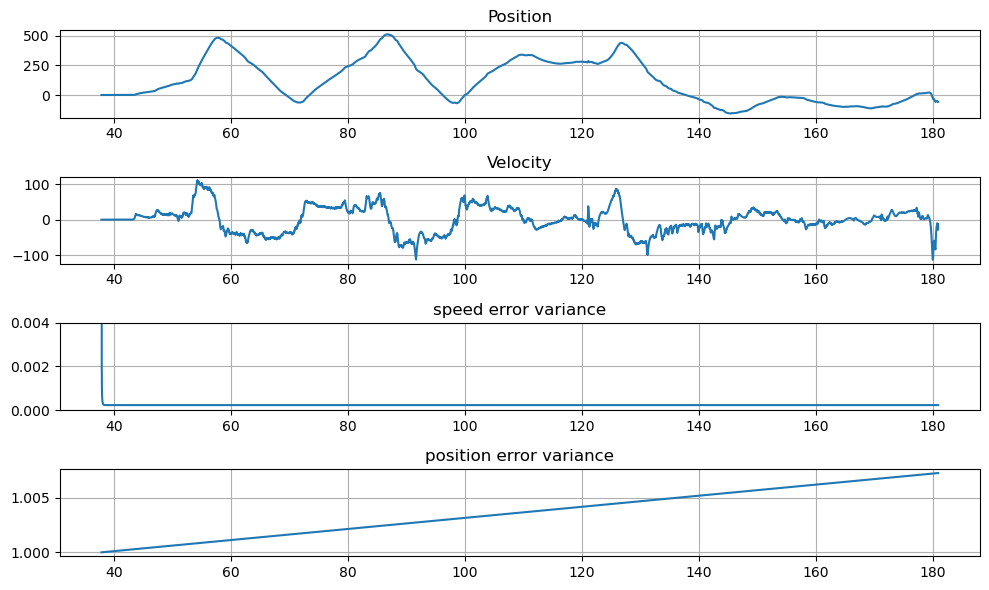

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1)
fig.set_size_inches(10, 6)

ax1.plot(time_s, vflow_filtered[0,:], label='filtered Flow Position')
ax1.set_title('Position')
ax1.grid(True) 

ax2.plot(time_s, vflow_filtered[1,:], label='filtered Flow Velocity')
ax2.set_title('Velocity')
ax2.grid(True) 

# find the small eigenvalue of the covariance matrix
ax3.plot(time_s, kf_cov_eigenvals[1,:], label='filtered speed error variance')
ax3.set_title('speed error variance')
ax3.grid(True) 
ax3.set_ylim([0,0.004])

ax4.plot(time_s, kf_cov_eigenvals[0,:], label='filtered position error variance')
ax4.set_title('position error variance')
ax4.grid(True) 


plt.tight_layout()
plt.show()

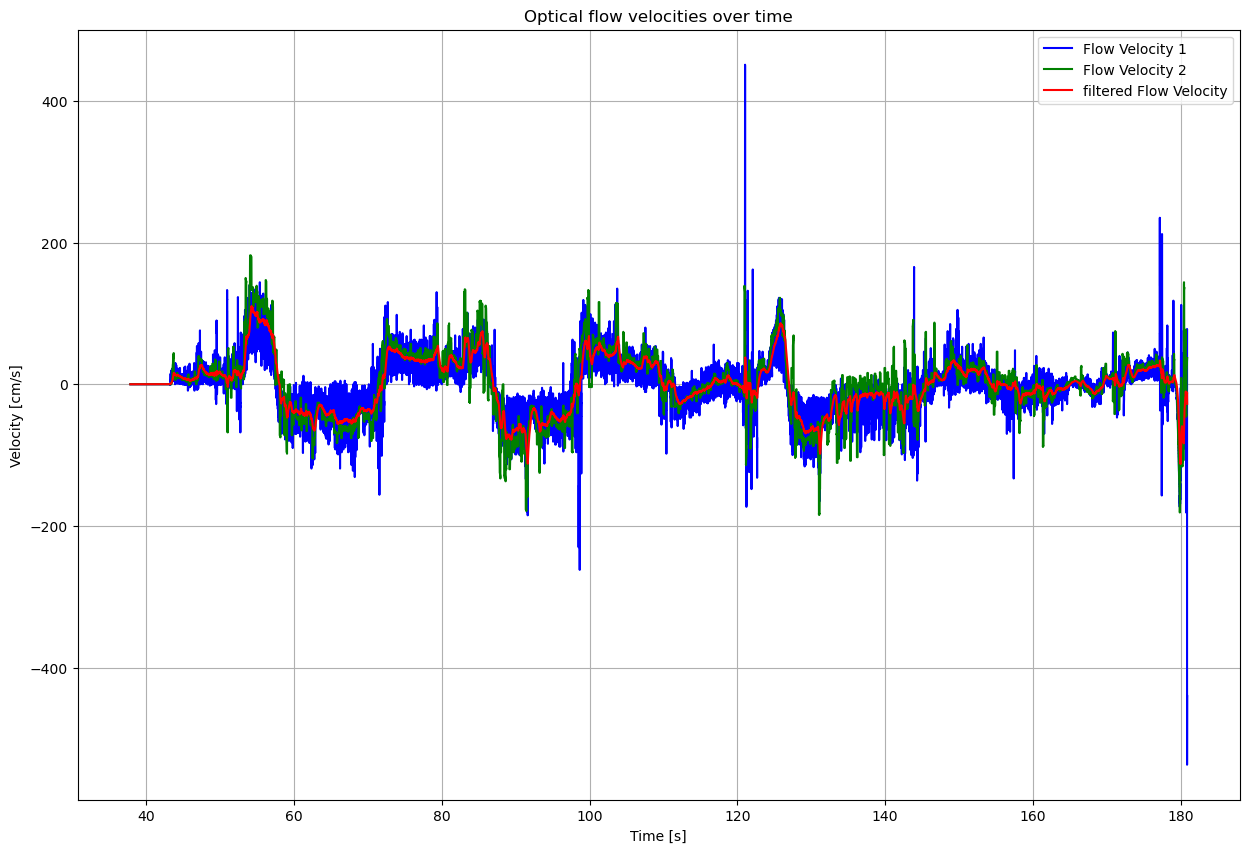

In [12]:
time_s = time_us * 1e-6
plt.figure(figsize=(15, 10))
plt.plot(time_s,flow_velocity_1_cms, label='Flow Velocity 1', color='blue')
plt.plot(time_s, flow_velocity_2_cms, label='Flow Velocity 2', color = 'green')
plt.plot(time_s, vflow_filtered[1,:], label='filtered Flow Velocity', color='red')
plt.grid(True)


plt.title("Optical flow velocities over time")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [cm/s]")

plt.legend()
plt.show()

we can see that the filter is not doing a good job. we need to tune the values of Q and R to achieve better results.
we will try to use the differnces between the sensor measurements as a proxy of the measurement covariance.

#### assumption
in order to proceed with this approach we must assume that the sensors covariace = 0

$$
R_{ij} = 0 \qquad (i \ne j)
$$

which, with the found variance of the measurement difference, we will assume that the measurement covariance matrix will equal:

$$
R = \begin{bmatrix}
    var & 0 \\
    0 & var\\
\end{bmatrix}
$$

we can also utilize the differences in time measurement interval but the proper was of dealing with these is to include them in matrix A so we will ignore this source for now

### redefining the kalman filter

we are now doing to create anotoher instance of the KF now with the revised R value and test the results


In [11]:
# create state observer variables
kalman_dt = np.average(dt) * 1e-6  # convert to seconds

A = np.array([[1, kalman_dt],
              [0, 1]])
C = np.array([[0, 1],
              [0, 1]])
Q = np.eye(2)

R = np.array([[var1, 0],
              [0, var1]])

P0 = np.eye(2)

x0 = np.zeros([2,1])

# initialize kalman filter
kf_v2 = vflowKalmanFilterV1(A, C, Q, R, P0, x0) 

NameError: name 'var1' is not defined

In [ ]:
vflow_filtered_n2 = np.zeros([2,len(flow_velocity_1_cms)])

for i in range(len(flow_velocity_1_cms)):
    y = np.array([[flow_velocity_1_cms[i]],
                  [flow_velocity_2_cms[i]]])
    # predict next state
    kf_v2.predict()
    #update prediction according to readings
    kf_v2.update(y)
    
    vflow_filtered_n2[:,i] = kf_v2.x.flatten()

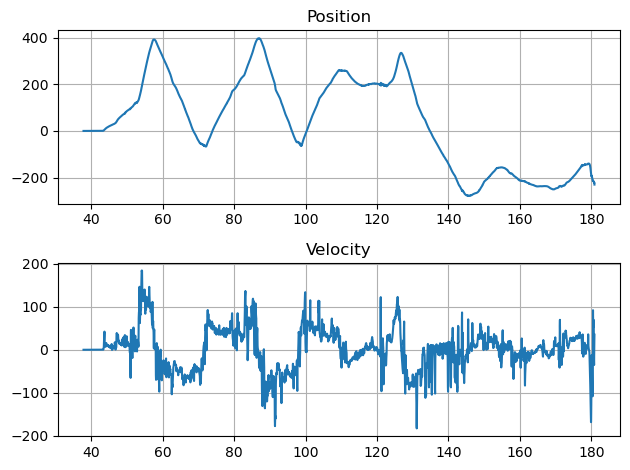

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

ax1.plot(time_s, vflow_filtered_n2[0,:], label='filtered Flow Position')
ax1.set_title('Position')
ax1.grid(True) 

ax2.plot(time_s, vflow_filtered_n2[1,:], label='filtered Flow Velocity')
ax2.set_title('Velocity')
ax2.grid(True) 

plt.tight_layout()
plt.show()

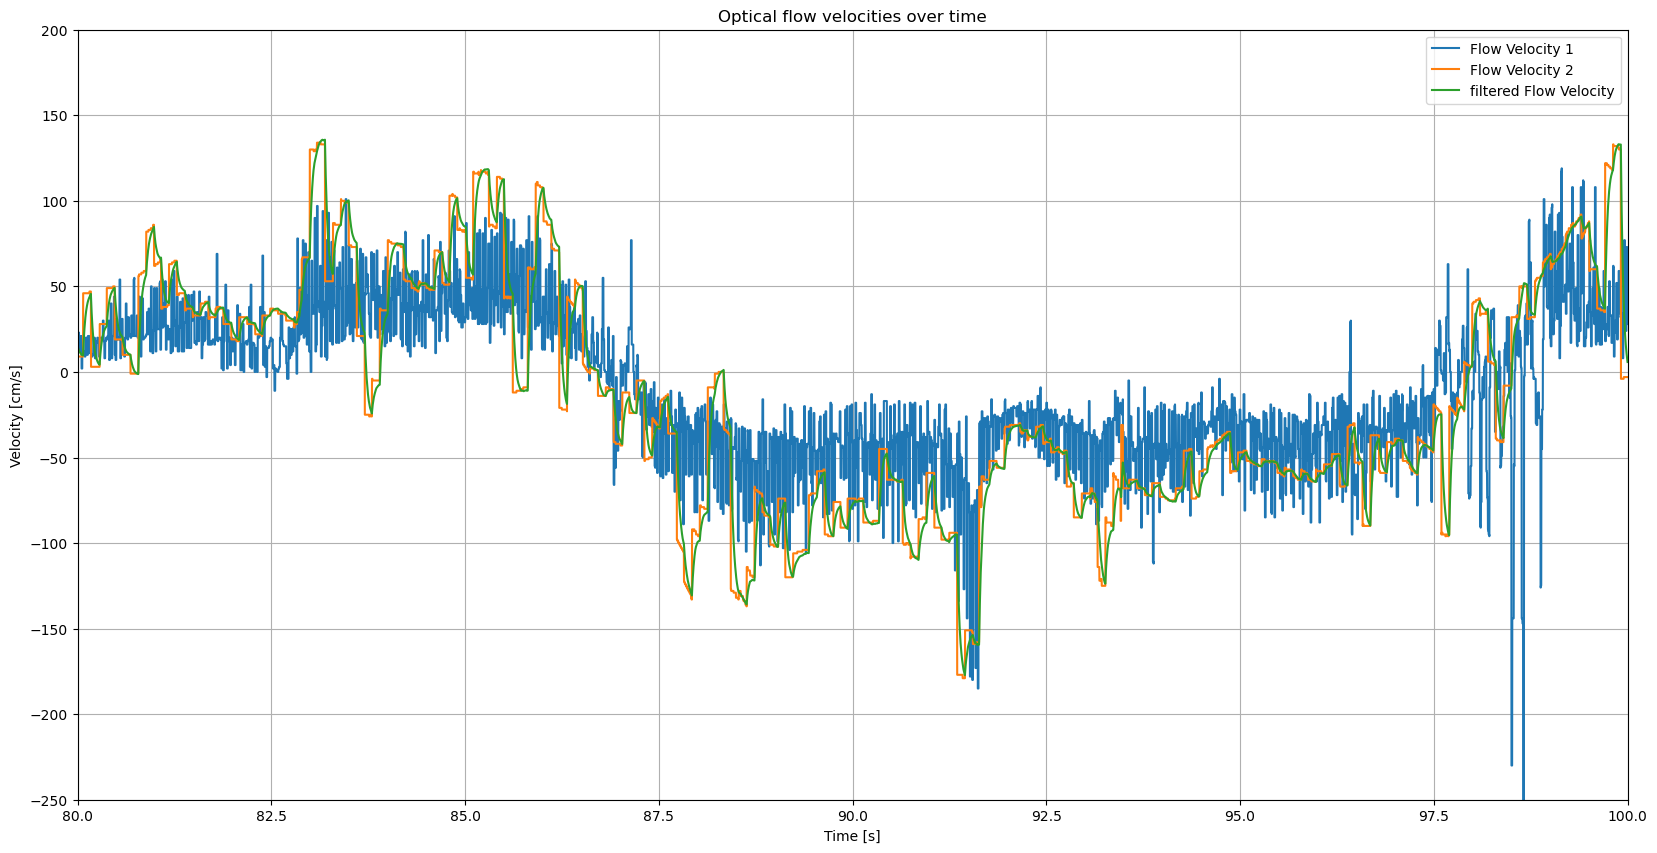

In [ ]:
time_s = time_us * 1e-6
plt.figure(figsize=(20, 10))
plt.plot(time_s,flow_velocity_1_cms, label='Flow Velocity 1')
plt.plot(time_s, flow_velocity_2_cms, label='Flow Velocity 2')
plt.plot(time_s, vflow_filtered_n2[1,:], label='filtered Flow Velocity')
plt.grid(True);


plt.title("Optical flow velocities over time")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [cm/s]")
plt.xlim([80,100])
plt.ylim([-250,200])


plt.legend()
plt.show()

In [ ]:
time_s = time_us * 1e-6
plt.figure(figsize=(20, 10))
plt.plot(time_s, vflow_filtered_n2[2,:], label='filtered Flow Velocity')
plt.grid(True);


plt.title("Optical flow velocities over time")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [cm/s]")
plt.xlim([80,100])


plt.legend()
plt.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

<Figure size 2000x1000 with 0 Axes>

we can see that the new kalman filter is less noisy but not to a greate extent

# Summary

in this excersize we implimented a recursive kalman filter. kalman filter is an optimal state observer which can be implemented recursively to achieve efficient and fast signal filtration.

we can improve the filter in the following ways:
1. get data regarding the sensors covariance matrix
2. get better extimation of the process error cov matrix
3. enter the measurement time into the filter and updating the plant A on each iteration

other methods of filtering the signals:
1. complementary filter - can be used in order to attach FR domain filters to each of the sensors and than combine the result
2. conducting an FFT and adding simple LPF filter after the sensor's required bandwidth
3. moving average 

I will stop this section for now. hope that it is enough